# ❤️ Heart Attack (MI) Detection from ECG (PTB-XL Dataset)

This notebook performs **binary classification** (MI vs Non-MI) using:

### 🔹 Logistic Regression (features)  
### 🔹 Random Forest (features)  
### 🔹 1D Convolutional Neural Network (raw ECG)

We use:
- **PTB-XL 500 Hz ECG signals**
- **Single Lead (Lead II)**
- **Simple 5-feature extraction** for ML models
- **Raw time-series** for CNN
- **Basic evaluation:** Accuracy, Precision, Recall, F1, Confusion Matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install wfdb
# %pip install tensorflow.keras

In [1]:
%pip install --upgrade tensorflow jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currentl

In [2]:
import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

DATASET_PATH = "/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
META_FILE_PTB = os.path.join(DATASET_PATH, "ptbxl_database.csv")
META_FILE_SCP = os.path.join(DATASET_PATH, "scp_statements.csv")
ARTIFACTS_DIR = "artifacts"
SEED=42; LEAD_IDX=1; SAMPLE_RATE=500; TEST_SIZE=0.2; MAX_RECORDS=5000
CNN_EPOCHS=40; BATCH_SIZE=32
# Path(ARTIFACTS_DIR).mkdir(exist_ok=True)
# Path(f"{ARTIFACTS_DIR}/models").mkdir(exist_ok=True)
# Path(f"{ARTIFACTS_DIR}/results").mkdir(exist_ok=True)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
sns.set(style="whitegrid")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.8.1, so it will not be used.
  warnings.warn(


## Helper Functions

In [3]:
def safe_eval_scp(x):
    try: return eval(x) if isinstance(x,str) else x
    except: return {}

def ensure_len(sig, expected):
    if len(sig)>expected: return sig[:expected]
    if len(sig)<expected: return np.concatenate([sig, np.zeros(expected-len(sig))])
    return sig

def normalize_per_record(X):
    # X: (n_samples, signal_len)
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True) + 1e-8
    return (X - m) / s

def print_result(res):
    print(f"\nModel: {res["model"]}")
    print(f"Accuracy: {res['accuracy']:.2%}")
    print(f"Precision: {res['precision']:.2%}")
    print(f"Recall: {res['recall']:.2%}")
    print(f"F1 Score: {res['f1 score']:.2%}")

## Load Metadata

In [4]:
def load_metadata(max_records=MAX_RECORDS):
    ptb_df = pd.read_csv(META_FILE_PTB)
    scp_df = pd.read_csv(META_FILE_SCP, index_col=0)

    ptb_df["scp_codes"] = ptb_df["scp_codes"].apply(safe_eval_scp)

    mi_codes = scp_df[scp_df["diagnostic_class"] == "MI"].index.tolist()
    mi_codes_set = set(mi_codes)

    ptb_df["label"] = ptb_df["scp_codes"].apply(
        lambda d: 1 if any(code in mi_codes_set for code in d.keys()) else 0
    )

    ptb_df = ptb_df[ptb_df["filename_hr"].notna()].reset_index(drop=True)

    if max_records is not None and max_records < len(ptb_df):
        from sklearn.model_selection import train_test_split

        ptb_df, _ = train_test_split(
            ptb_df,
            train_size=max_records,
            stratify=ptb_df["label"],
            random_state=SEED,
        )
        ptb_df = ptb_df.reset_index(drop=True)

    return ptb_df


ptb_df = load_metadata()
print("Total records used:", len(ptb_df))
print("Label counts:")
print(ptb_df["label"].value_counts())
ptb_df[["ecg_id", "patient_id", "scp_codes", "filename_hr", "label"]]


Total records used: 5000
Label counts:
label
0    3744
1    1256
Name: count, dtype: int64


,ecg_id,patient_id,scp_codes,filename_hr,label
0,13748,15672.0,"{'NORM': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",records500/13000/13748_hr,0
1,1266,14284.0,"{'NORM': 100.0, 'SR': 0.0}",records500/01000/01266_hr,0
2,9681,11062.0,"{'NORM': 80.0, 'SARRH': 0.0}",records500/09000/09681_hr,0
3,6047,5293.0,"{'NORM': 100.0, 'SR': 0.0}",records500/06000/06047_hr,0
4,4737,20459.0,"{'ISCAL': 100.0, 'ISCIL': 100.0, 'SR': 0.0}",records500/04000/04737_hr,0
...,...,...,...,...,...
4995,13859,13767.0,"{'NDT': 100.0, 'SR': 0.0}",records500/13000/13859_hr,0
4996,5858,8202.0,{'CLBBB': 100.0},records500/05000/05858_hr,0
4997,10999,3777.0,"{'CLBBB': 100.0, 'SR': 0.0}",records500/10000/10999_hr,0
4998,3723,8287.0,{'PACE': 100.0},records500/03000/03723_hr,0


## Load One Signal and Smoke Test

Showing first 2 signals for sanity check...


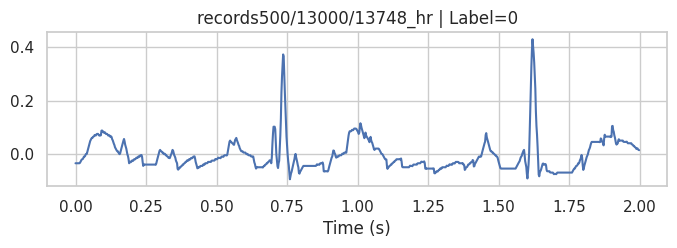

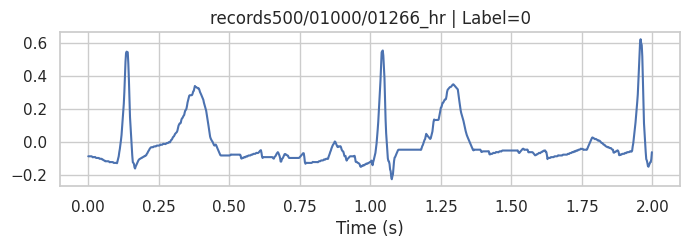

In [5]:
def load_signal_single(path_record, lead_idx=LEAD_IDX):
    try:
        recp=os.path.join(DATASET_PATH,path_record)
        sig,fields = wfdb.rdsamp(recp)
        return sig[:,lead_idx].astype(np.float32)
    except:
        return None

def smoke_test(df, count=2):
    print(f"Showing first {count} signals for sanity check...")
    for row in df.itertuples():
        sig = load_signal_single(row.filename_hr)
        if sig is None:
            continue

        sig = ensure_len(sig, SAMPLE_RATE * 10)
        t = np.arange(len(sig)) / SAMPLE_RATE

        plt.figure(figsize=(8,2))
        plt.plot(t[:1000], sig[:1000])  # first 2 seconds
        plt.title(f"{row.filename_hr} | Label={row.label}")
        plt.xlabel("Time (s)")
        plt.show()

        count -= 1
        if count == 0:
            return


smoke_test(df=ptb_df)


## Build Raw Dataset

In [6]:
def build_raw_dataset(df, lead_idx=LEAD_IDX):
    X, y, rec_ids = [], [], []

    for r in tqdm(df.itertuples(), desc="Loading ECG signals"):
        sig = load_signal_single(r.filename_hr, lead_idx=lead_idx)
        if sig is None:
            continue

        sig = ensure_len(sig, SAMPLE_RATE * 10)

        X.append(sig)
        y.append(r.label)
        rec_ids.append(r.filename_hr)

    X = np.stack(X)
    y = np.array(y)

    return X, y, rec_ids

X_raw, y_raw, rec_ids = build_raw_dataset(ptb_df)
X_raw = normalize_per_record(X_raw)
print("\nX_raw shape:", X_raw.shape, "y_raw shape:", y_raw.shape)
print("Label counts in y_raw:", np.unique(y_raw, return_counts=True))

Loading ECG signals: 5000it [1:21:21,  1.02it/s]



X_raw shape: (5000, 5000) y_raw shape: (5000,)
Label counts in y_raw: (array([0, 1]), array([3744, 1256]))


## Feature Extraction

In [8]:
def extract_features(sig):
    diff = np.diff(sig)

    return {
        "mean": float(np.mean(sig)),
        "std": float(np.std(sig)),
        "rms": float(np.sqrt(np.mean(sig**2))),
        "skew": float(skew(sig)),
        "kurtosis": float(kurtosis(sig)),
        "min": float(np.min(sig)),
        "max": float(np.max(sig)),
        "ptp": float(np.ptp(sig)),  # peak-to-peak
        "mean_abs_diff": float(np.mean(np.abs(diff))),
        "std_diff": float(np.std(diff)),
        "rms_diff": float(np.sqrt(np.mean(diff**2)))
    }

def extract_features_dataset(X):
    return pd.DataFrame([extract_features(s) for s in X])

df_features=extract_features_dataset(X_raw)
df_features['label']=y_raw
df_features.head()

,mean,std,rms,skew,kurtosis,min,max,ptp,mean_abs_diff,std_diff,rms_diff,label
0,-1.525879e-09,1.0,1.0,3.044143,14.803497,-2.089355,7.216058,9.305412,0.105057,0.225379,0.225379,0
1,-4.577637e-09,1.0,1.0,2.041422,3.957554,-1.649339,4.733467,6.382806,0.047180,0.120580,0.120580,0
2,0.000000e+00,1.0,1.0,0.940629,2.030131,-3.051377,5.225695,8.277072,0.052078,0.128265,0.128265,0
3,0.000000e+00,1.0,1.0,5.000584,33.074936,-1.109514,8.992976,10.102490,0.042775,0.181124,0.181124,0
4,4.577637e-09,1.0,1.0,4.036386,18.143793,-1.072922,5.961589,7.034512,0.053453,0.154185,0.154185,0


## Train Test Split

In [9]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw,
    y_raw,
    test_size=TEST_SIZE,
    stratify=y_raw,
    random_state=SEED
)

Xf_train=extract_features_dataset(X_train_raw).values
Xf_test=extract_features_dataset(X_test_raw).values
(Xf_train.shape, Xf_test.shape)

((4000, 11), (1000, 11))

## All Models Trainer and Evaluator

In [10]:
def train_logistic_regression(X_train, y_train):
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_train)
    lr = LogisticRegression(
        max_iter=1000,
        random_state=SEED,
        class_weight='balanced'
    )
    lr.fit(Xs_train, y_train)
    return lr,scaler


def train_random_forest(X_train,y_train):
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced_subsample',
        max_depth=None,
        min_samples_leaf=3
    )
    rf.fit(X_train,y_train)
    return rf

def build_cnn(input_shape):
    m = Sequential([
        Conv1D(32, 7, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def train_cnn(model, X_train, y_train, epochs=CNN_EPOCHS):
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    hist = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        verbose=2,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[es]
    )
    return model, hist

def evaluate_model(model, X_test, y_test, name, scaler=None, is_cnn=False):
    if scaler and not is_cnn: X_in=scaler.transform(X_test)
    else: X_in=X_test

    if is_cnn:
        y_score=model.predict(X_in).ravel()
        y_pred=(y_score>0.5).astype(int)
    else:
        y_pred=model.predict(X_in)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1 score": f1
    }

## Logistic Regression Training and Evaluation

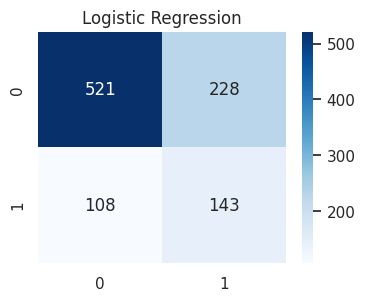


Model: Logistic Regression
Accuracy: 66.40%
Precision: 38.54%
Recall: 56.97%
F1 Score: 45.98%


In [11]:
lr,scaler_lr=train_logistic_regression(Xf_train,y_train)
# joblib.dump(lr,f"{ARTIFACTS_DIR}/models/logistic.joblib")
res_lr=evaluate_model(lr,Xf_test,y_test,"Logistic Regression",scaler_lr)
print_result(res_lr)

## Random Forest Training and Evaluation

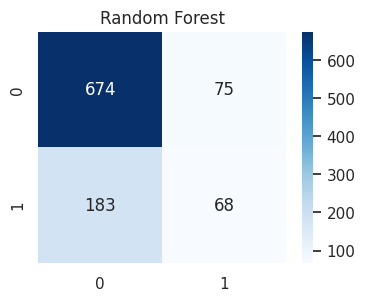


Model: Random Forest
Accuracy: 74.20%
Precision: 47.55%
Recall: 27.09%
F1 Score: 34.52%


In [12]:
rf=train_random_forest(Xf_train,y_train)
# joblib.dump(rf,f"{ARTIFACTS_DIR}/models/rf.joblib")
res_rf=evaluate_model(rf,Xf_test,y_test,"Random Forest")
print_result(res_rf)

## CNN Training and Evaluation

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
100/100 - 76s - 760ms/step - accuracy: 0.6012 - loss: 0.6830 - val_accuracy: 0.6050 - val_loss: 0.6630
Epoch 2/40
100/100 - 70s - 702ms/step - accuracy: 0.6859 - loss: 0.5989 - val_accuracy: 0.6725 - val_loss: 0.6581
Epoch 3/40
100/100 - 61s - 610ms/step - accuracy: 0.7563 - loss: 0.5043 - val_accuracy: 0.6525 - val_loss: 0.6419
Epoch 4/40
100/100 - 80s - 803ms/step - accuracy: 0.8353 - loss: 0.3974 - val_accuracy: 0.6775 - val_loss: 0.6491
Epoch 5/40
100/100 - 81s - 811ms/step - accuracy: 0.8900 - loss: 0.2827 - val_accuracy: 0.6988 - val_loss: 0.7121
Epoch 6/40
100/100 - 59s - 591ms/step - accuracy: 0.9103 - loss: 0.2594 - val_accuracy: 0.7387 - val_loss: 0.7975
Epoch 7/40
100/100 - 62s - 623ms/step - accuracy: 0.9191 - loss: 0.2129 - val_accuracy: 0.7175 - val_loss: 0.8860
Epoch 8/40
100/100 - 60s - 595ms/step - accuracy: 0.9469 - loss: 0.1571 - val_accuracy: 0.6737 - val_loss: 1.0558
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step


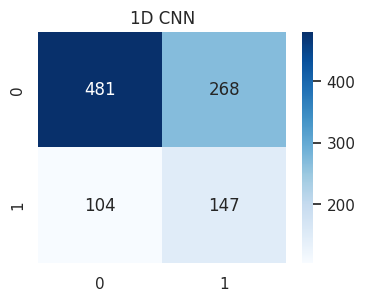


Model: 1D CNN
Accuracy: 62.80%
Precision: 35.42%
Recall: 58.57%
F1 Score: 44.14%


In [13]:
Xc_train = np.expand_dims(X_train_raw,axis=2)
Xc_test = np.expand_dims(X_test_raw,axis=2)
cnn = build_cnn((Xc_train.shape[1],1))
cnn, hist = train_cnn(cnn,Xc_train,y_train)
# cnn.save(f"{ARTIFACTS_DIR}/models/cnn.h5")
res_cnn=evaluate_model(cnn,Xc_test,y_test,"1D CNN",is_cnn=True)
print_result(res_cnn)

## Final Result Of All Models

In [14]:
results_df = pd.DataFrame([res_lr,res_rf,res_cnn])

results_df.style.format({
    'accuracy': '{:.2%}',
    'precision': '{:.2%}',
    'recall': '{:.2%}',
    'f1 score': '{:.2%}'
})

,model,accuracy,precision,recall,f1 score
0,Logistic Regression,66.40%,38.54%,56.97%,45.98%
1,Random Forest,74.20%,47.55%,27.09%,34.52%
2,1D CNN,62.80%,35.42%,58.57%,44.14%


# 📌 Conclusion

We trained and compared **three models** for MI detection:

### ✔ Logistic Regression (very fast, uses simple features)  
### ✔ Random Forest (better than LR in many cases)  
### ✔ 1D CNN (uses raw ECG, learns automatically)

Evaluation metrics included:
- Accuracy  
- Precision  
- Recall  
- F1  
- Confusion Matrix  